# Demo

In [31]:
import pyroadacoustics as pyroad
import numpy as np
import scipy.signal
from scipy.io import wavfile
import matplotlib.pyplot as plt

# Define sampling frequency
fs = 8000

# Define source signal
t = np.arange(0,5,1/fs)

# Sinusoidal signal
f = 2000
src_signal = np.sin(2 * np.pi * f * t)

# White noise signal
# src_signal = np.random.randn(len(t))

# Define acoustic scene
T = 20
p = 1
h_rel = 50

env = pyroad.Environment(fs = fs, temperature = T, pressure = p, rel_humidity = h_rel)

# Add sound source
env.add_source(np.array([3,20,1]), trajectory_points=np.array([[3,20,1], [3,-20,1]]), source_velocity=np.array([5]), signal=src_signal)

# Add microphone array
env.add_microphone_array(np.array([[0,0,1]]))

# Add background noise
# env.set_background_noise(SNR = 0)

# Set simulation parameters
interp_method = "Allpass"
include_reflection = True
include_air_absorption = True

env.set_simulation_params(interp_method, include_reflection, include_air_absorption)

# Run simulation 
signal = env.simulate()

# Compute spectrogram of received signal
ff, tt, Sxx = scipy.signal.spectrogram(signal[0], fs = fs)


Text(0, 0.5, 'Frequency [Hz]')

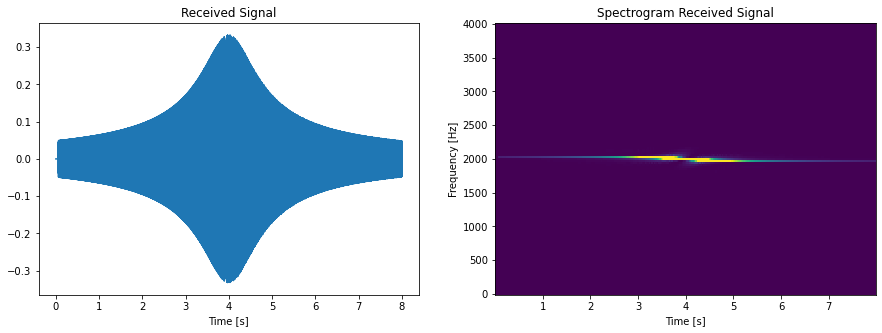

In [32]:
# Plots
fig, axs = plt.subplots(1,2, figsize = (15,5))

# Waveform Received Signal
axs[0].plot(np.arange(len(signal[0]))/fs, signal[0])
axs[0].set_title('Received Signal')
axs[0].set_xlabel('Time [s]')

# Spectrogram Received Signal
axs[1].pcolormesh(tt, ff, Sxx, shading='auto', vmax = 0.0004, rasterized=True)
axs[1].set_title('Spectrogram Received Signal')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Frequency [Hz]')



In [22]:
# Save Audio File
from scipy.io import wavfile
# Avoid loud output file
signal[0] = signal[0] / max(abs(signal[0]))
wavfile.write('demo_audio.wav', fs, signal[0])